In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import pandas as pd
import plotly.express as px

from spot.utils import (
    cst,
    read_file,
    write_file,
    seq_flatten,
    proj_root,
    tqdm,
)
from spot.type_env import (
    collect_annotations,
    MypyChecker,
    AnnotPath,
    mypy_checker,
    TypeInfEnv,
    TypeInfState,
    TypeInfAction,
    SelectAnnotations,
)
from spot.data import GitRepo

from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from typing import *

os.chdir(proj_root())

datadir = Path(os.getenv("datadir"))
repos_dir = datadir / "SPOT-data/repos"

useful_repos_path = proj_root() / "scripts" / "useful_repos.pkl"
with useful_repos_path.open("rb") as f:
    useful_repos: list[GitRepo] = pickle.load(f)


In [3]:
load_trained = True

if load_trained:
    model_path = datadir / "checkpoints/saved/SPOT-CodeT5-with_margin"
else:
    model_path = "Salesforce/codet5-base"

import torch
from transformers import (
    RobertaTokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
)
from transformers.models.t5 import T5ForConditionalGeneration

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer: RobertaTokenizer = RobertaTokenizer.from_pretrained(model_path)
model: T5ForConditionalGeneration
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
max_target_length = 256


/home/jiayi/Projects/SPOT/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [6]:
from spot.data import tokenize_masked, mask_type_annots, chunk_masked_code

test_code = """
# a, b, c are all of type int.
def int_add(a: int, b: int, c: int) -> int:
    return a + b + c
"""


def run_model(code: str):
    tks = tokenize_masked(mask_type_annots(code), tokenizer, device)
    loss = model.forward(**tks).loss
    dec = model.generate(
        tks["input_ids"],
        max_length=128,
        num_beams=10,
        # do_sample=True,
    )[0]
    return {"loss": loss, "generation": tokenizer.decode(dec)}


run_model(test_code)


{'loss': tensor(3.4084, device='cuda:0', grad_fn=<NllLossBackward0>),
 'generation': '<pad><s><extra_id_0>typing.Union[int, float, int]<extra_id_1>typing.Union[int, float, int, float, float]<extra_id_2>typing.Union[int, float, float, float, float, float]<extra_id_3>typing.Union[int, float, float, float, float, float]</s>'}

In [49]:
from spot.data import load_or_process_datasets

with_margin = True

margin_tag = "with_margin" if with_margin else "no_margin"
ctx_margin = tokenizer.model_max_length // 4 if with_margin else 0

tk_datasets, repos_split = load_or_process_datasets(
    datadir / f"SPOT-data/repos-processed-{margin_tag}",
    tokenizer,
    repos_dir,
    repos_test=useful_repos[0:50],
    repos_valid=useful_repos[50:90],
    repos_train=useful_repos[90:],
    regenerate=False,
    ctx_margin=ctx_margin,
)


Loading datasets from: /mnt/data0/jiayi/SPOT-data/repos-processed-with_margin


In [50]:
import numpy as np

print(
    "average label length: ",
    np.mean([len(ts) for ts in tk_datasets["train"]["labels"] if bool(ts)]),
)


average label length:  17.262881004381807


In [9]:
import wandb

if not load_trained:
    wandb.init(
        project=f"SPOT-CodeT5-{margin_tag}",
        config={"dataset": "full", "ctx_margin": ctx_margin},
    )

In [10]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback
from transformers.trainer import Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer, model)
for k, d in tk_datasets.items():
    tk_datasets[k] = d.remove_columns('types')
    tk_datasets[k].set_format("torch", columns=["input_ids", "labels"])

if not load_trained:
    args = Seq2SeqTrainingArguments(
        datadir / f"checkpoints/SPOT-CodeT5-{margin_tag}",
        evaluation_strategy="steps",
        eval_steps=100,
        logging_steps=100,
        prediction_loss_only=True,
        save_strategy="steps",
        save_steps=500,
        save_total_limit=3,
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        weight_decay=0.01,
        num_train_epochs=3,
        load_best_model_at_end=True,
        fp16=True,
        push_to_hub=False,
        report_to="wandb",
    )

    trainer: Trainer = Seq2SeqTrainer(
        model,
        args,
        train_dataset=tk_datasets["train"],
        eval_dataset=tk_datasets["valid"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(2)],
    )

In [11]:
if not load_trained:
    init_perf = trainer.evaluate(max_length=max_target_length)
    print("initial performance:", init_perf)
    trainer.train()

In [13]:
if not load_trained:
    print("Final performance:", trainer.evaluate(max_length=max_target_length))

In [51]:
# test accuracy on the test set
from datasets import Dataset
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, EvalPrediction
from transformers.trainer import Trainer
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from spot.model import compute_metrics


testset = tk_datasets["test"].remove_columns('types')
testset.set_format('torch', columns=["input_ids", "labels"])
max_target_length = 160

test_args = Seq2SeqTrainingArguments(
    datadir / f"checkpoints/test/SPOT-CodeT5-{margin_tag}",
    per_device_eval_batch_size=16,
    fp16=True,
    eval_accumulation_steps=8,
    predict_with_generate=True,
    generation_max_length=max_target_length,
    generation_num_beams=10,
)

test_trainer: Trainer = Seq2SeqTrainer(
    model,
    args=test_args,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model),
    tokenizer=tokenizer,
    compute_metrics=lambda e: compute_metrics(e.predictions, e.label_ids, tokenizer),
)

eval_result = test_trainer.evaluate(testset, metric_key_prefix="test")


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the evaluation set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: types. If types are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3956
  Batch size = 16
/home/jiayi/Projects/SPOT/.venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


decoding types:   0%|          | 0/3956 [00:00<?, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


loss: 0.4671325981616974
accuracy_partial: 0.7676420934158694
accuracy_full: 0.6954417557681486
n_predictions: 17761
n_labels: 17770


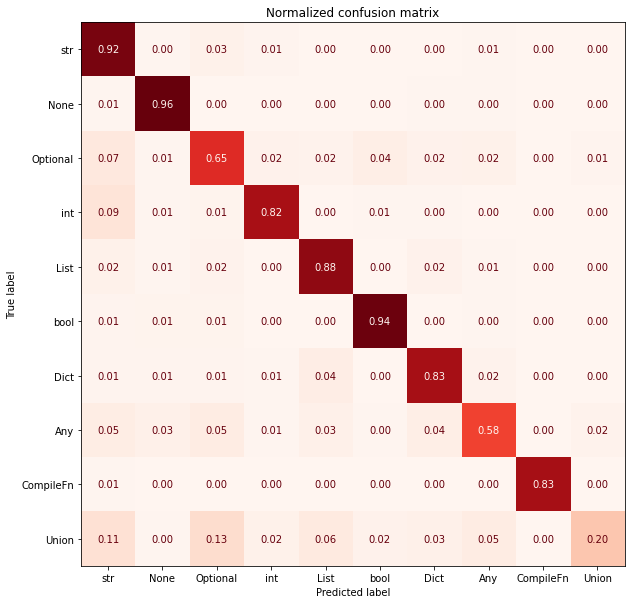

       label  accuracy  count
0        str  0.919880   3008
1       None  0.955245   2145
2   Optional  0.650000   1400
3        int  0.822284   1086
4       List  0.876232    913
5       bool  0.941397    802
6       Dict  0.829721    646
7        Any  0.580135    443
8  CompileFn  0.830049    406
9      Union  0.203065    261

In [52]:
from spot.type_env import normalize_type_name
from spot.utils import confusion_matrix_top_k, accuracy_by_labels
from IPython.display import display_pretty


ConfusionMatrixDisplay.from_predictions

def display_conf_matrix(conf_matrix: dict):
    match conf_matrix:
        case {"matrix": cm, "labels": labels}:
            n_labels = len(labels)
            fig, ax = plt.subplots(figsize=(n_labels, n_labels))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
            disp.plot(cmap="Reds", values_format=".2f", ax=ax, colorbar=False)
            plt.title("Normalized confusion matrix")
            plt.show()


for k in ["loss", "accuracy_partial", "accuracy_full", "n_predictions", "n_labels"]:
    print(f"{k}:", eval_result[f"test_{k}"])

pred_types = list(map(normalize_type_name, eval_result["test_pred_types"]))
label_types = list(map(normalize_type_name, eval_result["test_label_types"]))
conf_matrix = confusion_matrix_top_k(pred_types, label_types, 10)
display_conf_matrix(conf_matrix)
accs = accuracy_by_labels(pred_types, label_types, 10)
stats = []
for t, n in Counter(label_types).most_common(10):
    stats.append({"label": t, "accuracy": accs[t], "count": n})
display_pretty(pd.DataFrame(stats))


In [42]:
wandb.finish()


eval/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▁▁▂▁▁▁▁▁▁▂▁▁▁▂▂▁▂▁
eval/samples_per_second,▁██▇██████▇███▇▇█▇█
eval/steps_per_second,▁██▇██████▇███▇▇█▇█
test/accuracy_full,▁
test/accuracy_partial,▁
test/loss,▁
test/n_labels,▁
test/n_predictions,▁
test/runtime,▁
test/samples_per_second,▁


In [53]:
preds_for_compile_fn = Counter()
for p, l in zip(pred_types, label_types):
    l: str
    if l.strip().endswith('Union'):
        preds_for_compile_fn[p.strip()] += 1

preds_for_compile_fn.most_common()

[('Union', 53),
 ('Optional', 34),
 ('str', 29),
 ('List', 16),
 ('Any', 13),
 ('T', 13),
 ('Tuple', 8),
 ('Expr', 8),
 ('Dict', 7),
 ('int', 6),
 ('bool', 5),
 ('SpecialForm', 5),
 ('Response', 4),
 ('HttpStatusCode', 3),
 ('TypingType', 2),
 ('float', 2),
 ('bytes', 2),
 ('TripDistance', 2),
 ('AvroModel', 2),
 ('BytesIO', 2),
 ('Iterable', 2),
 ('Symbol', 2),
 ('Form', 2),
 ('OASFileType', 1),
 ('Type', 1),
 ('None', 1),
 ('UnusableDataSource', 1),
 ('Vec3D', 1),
 ('Session', 1),
 ('datetime', 1),
 ('StrIntT', 1),
 ('Tensor', 1),
 ('CrawlOut', 1),
 ('S3Storage', 1),
 ('DefaultStorage', 1),
 ('Storage', 1),
 ('UserTypeEnum', 1),
 ('AvroField', 1),
 ('date', 1),
 ('LogicalTypes', 1),
 ('Keyword', 1),
 ('LispReaderForm', 1),
 ('Namespace', 1),
 ('IPersistentList', 1),
 ('DefTypeASTGenerator', 1),
 ('FunctionDef', 1),
 ('ISeq', 1),
 ('Set', 1),
 ('MetaGetter', 1),
 ('IForm', 1),
 ('HostField', 1),
 ('VarRef', 1),
 ('Local', 1),
 ('PyDict', 1),
 ('RV', 1),
 ('Xlsb', 1),
 ('BufferedIOBase